In [1]:
# Import packages and other setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import seaborn as sns
import datetime as dt
from sklearn.metrics import mean_squared_error
from scipy import stats
import pickle
import statsmodels.api as sm
from statsmodels.distributions.empirical_distribution import ECDF
import scipy.integrate as integrate
from bisect import bisect_left

In [2]:
plt.rcParams['figure.figsize'] = (15,10)
sns.set()

In [650]:
def pprint(a):
    print(np.array2string(a, precision=2, separator=',',suppress_small=True))

## Dummy dataset functions

In [5]:
def normal_samples(num_samples, mu = 0.8, sigma = 0.2):
    s = np.random.normal(mu, sigma, num_samples)
    s = np.clip(s, a_min = 0, a_max = 1)
    return s

In [6]:
def uniform_samples(num_samples, low=0, high=1):
    s = np.random.uniform(low,high,num_samples)
    return s

In [7]:
#create some dummy data for experimentation with a fixed spend rate
def dummy_dataset(num_samples):
    df = pd.DataFrame()
    df['value'] = normal_samples(num_samples)
    df['competing_bid'] = normal_samples(num_samples,0.6,0.3)
    #df['competing_bid'] = uniform_samples(num_samples,0.3,0.6)
    return df

In [8]:
#create some dummy data for experimentation with a changing spend rate
def changing_spend_dummy_dataset(num_samples):
    if int(num_samples)%10:
        raise Exception("num_samples should be a multiple of 10")
    num_samples = (int)(num_samples/10)
    val = np.empty((0))
    for i in range(10):
        val = np.append(val, uniform_samples(num_samples, 1 + 0.1*i, 2 + 0.1*i))
    df = pd.DataFrame()
    df['value'] = val
    df['competing_bid'] = 1
    return df

In [9]:
#returns the approximate spend rate by using for a data_sampler
def approximate_spend_rate(data_sampler, budget, num_samples, num_trials):
    spend_curve = np.zeros((num_samples))
    for i in range(num_trials):
        ss = data_sampler(int(num_samples))
        dft = hindsight_strategy(ss, budget)
        spend_curve += dft['spend']
    spend_sum = np.sum(spend_curve)
    if spend_sum != 0:
        spend_curve = (spend_curve/spend_sum)*budget
    return spend_curve

# Episodic dummy data with fixed price

In [10]:
#create some dummy data for experimentation with a changing spend rate
def moving_uniform(num_episodes, samples_per_episode):
    val = np.empty((0))
    episode = np.empty((0))
    for i in range(num_episodes):
        val = np.append(val, uniform_samples(samples_per_episode, 1 + 0.1*i, 2 + 0.1*i))
        episode = np.append(episode, np.full(samples_per_episode, i))
    df = pd.DataFrame()
    df['value'] = val
    df['competing_bid'] = 1
    df['episode'] = episode
    return df

In [11]:
#create some dummy data for experimentation with a changing spend rate
def moving_normal(num_episodes, samples_per_episode):
    val = np.empty((0))
    episode = np.empty((0))
    for i in range(num_episodes):
        val = np.append(val, np.random.normal(2 + 0.2*i, 1 + 0.1*i, samples_per_episode))
        episode = np.append(episode, np.full(samples_per_episode, i))
    df = pd.DataFrame()
    df['value'] = np.clip(val,0,10)
    df['value'].clip
    df['competing_bid'] = 1
    df['episode'] = episode
    return df

def lognorm_val_fp(num_episodes, samples_per_episode, val_mean, val_std):
    val = np.empty((0))
    price = np.empty((0))
    episode = np.empty((0))
    for i in range(num_episodes):
        xx = np.random.lognormal(val_mean[i], val_std[i], samples_per_episode)
        val = np.append(val, xx)
        ##count, bins, ignored = plt.hist(xx, 100, density=True, align='mid', range = (0,10))
        episode = np.append(episode, np.full(samples_per_episode, i))
    df = pd.DataFrame()
    df['value'] = val
    df['value']  = df['value'].clip(lower=0, upper = 100)
    df['competing_bid'] = 1
    df['episode'] = episode
    return df

# Episodic dummy data with changing price

In [13]:
#create some dummy data for experimentation with a changing spend rate
def uniform_val_normal_price(num_episodes, samples_per_episode):
    val = np.empty((0))
    price = np.empty((0))
    episode = np.empty((0))
    for i in range(num_episodes):
        val = np.append(val, uniform_samples(samples_per_episode, 1 , 1.2**i))
        price = np.append(price, np.random.normal( 1.05**i , 1, samples_per_episode))
        episode = np.append(episode, np.full(samples_per_episode, i))
    df = pd.DataFrame()
    price = np.clip (price, 0.1, 100)
    df['value'] = val
    df['competing_bid'] = price
    df['competing_bid'] = df['competing_bid'].clip(lower=0)
    df['episode'] = episode
    return df

In [14]:
def normal_val_normal_price(num_episodes, samples_per_episode, val_mean, price_mean):
    val = np.empty((0))
    price = np.empty((0))
    episode = np.empty((0))
    for i in range(num_episodes):
        val = np.append(val, np.random.normal(val_mean[i], 1, samples_per_episode))
        price = np.append(price, np.random.normal(price_mean[i], 1, samples_per_episode))
        episode = np.append(episode, np.full(samples_per_episode, i))
    df = pd.DataFrame()
    df['value'] = val
    df['competing_bid'] = price
    df['competing_bid'] = df['competing_bid'].clip(lower=0)
    df['episode'] = episode
    return df

In [15]:
def lognorm_val_maxlognorm_price2(num_episodes, samples_per_episode, val_mean, price_mean, competition = 5):
    val = np.empty((0))
    price = np.empty((0))
    episode = np.empty((0))
    for i in range(num_episodes):
        val = np.append(val, np.random.lognormal(val_mean[i], 1, samples_per_episode))
        price = np.append(price, np.max (np.random.lognormal(price_mean, 1, (samples_per_episode, 10)), axis = 1) )
        episode = np.append(episode, np.full(samples_per_episode, i))
    df = pd.DataFrame()
    df['value'] = val
    df['value']  = df['value'].clip(lower=0, upper = 100)
    df['competing_bid'] = price
    df['competing_bid'] = df['competing_bid'].clip(lower=0, upper = 100)
    df['episode'] = episode
    return df

In [16]:
def lognorm_val_maxlognorm_price(num_episodes, samples_per_episode, val_mean, price_mean, val_std, price_std):
    val = np.empty((0))
    price = np.empty((0))
    episode = np.empty((0))
    comp = price_mean.shape[1]
    for i in range(num_episodes):
        val = np.append(val, np.random.lognormal(val_mean[i], val_std, samples_per_episode))
        comp_bids = np.zeros((samples_per_episode, comp))
        for comp in range(comp):
            comp_bids[:,comp] = np.random.lognormal(price_mean[comp][i], price_std, samples_per_episode)
        price = np.append(price, np.max (comp_bids, axis = 1))
        #count, bins, ignored = plt.hist(price, 100, density=True, align='mid', range = (0,10))

        episode = np.append(episode, np.full(samples_per_episode, i))
    df = pd.DataFrame()
    df['value'] = val
    df['value']  = df['value'].clip(lower=0, upper = 100)
    df['competing_bid'] = price
    df['competing_bid'] = df['competing_bid'].clip(lower=0, upper = 100)
    df['episode'] = episode
    return df

# Pacing algorithms

## Hindsight strategy

In [17]:
#ex. post optimal strategy
def hindsight_strategy(df = dummy_dataset(100), budget = 15):		
    """ A function to implement the ex. post optimal pacing strategy for a budget constraint campaign
    Sorts the impressions by value/competing bid and buys all top impressions till runs out of budget

    Args:
        df: The imput dataframe containing 'value' and 'competing_bid' with each row as one impression
        budget: The total budget for the campaign

    Returns:
        A dataframe containing with the following columns for each impression
        bang_per_buck: The value per dollar for the impression
        won: A binary flag indicating if the impression was won
        spend: Spend in this round
        utility: Utility obtained in this round
        paced_impression_bid: Paced bid
        value_obtianed: value_obtained in this round (i.e value*won)
        pacing_multiplier: The pacing multiplier used to obtained the shaded bid
        index: The index of the impression in the input data

    """
    df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
    df = df.sort_values(by = 'bang_per_buck', ascending=False)
    df['utility'] = 0
    df['won'] = False
    df['spend'] = 0
    shade = 1.0
    for index,row in df.iterrows():
        if budget-row['competing_bid'] >=0 and row['bang_per_buck']>0:
            row['won'] = True
            row['utility'] = row['value'] - row['competing_bid']
            if row['competing_bid']==0:
                shade = np.infty
            else:
                shade = row['value']/row['competing_bid']
            budget = budget - row['competing_bid']
            df.loc[index] = row
        else:
            break
    #print(shade)
    df['paced_bid'] = df['value']/shade
    df.sort_index(inplace=True)
    df['spend'] = df['competing_bid']*df['won']
    df['index'] = df.index
    df['value_obtained'] = df['value']*df['won']
    df['pacing_multiplier'] = 1.0/shade
    #print(df.head())
    return df

## Adaptive pacing

In [18]:
#No regret adaptive pacing strategy
def adaptive_pacing_bg(df, target_spend, learning_rate = 0.001):
    """ A function to simulate an adaptive pacing strategy which attempts match the target spend

    Args:
        df: The imput dataframe containing 'value' and 'competing_bid' with each row as one impression
        target_spend: instantaneous target spend (not cumulative)

    Returns:
        A dataframe containing with the following columns for each impression
        won: A binary flag indicating if the impression was won
        spend: Spend in this round
        target_spend: Target spend rate in this round
        utility: Utility obtained in this round
        paced_bid: Paced impression bid
        value_obtained: value_obtained in this round (i.e value*won)
        pacing_multiplier: The pacing multiplier used to obtained the shaded bid
        index: The index of the impression in the input data
    """
        
    max_shading = 100
    budget = np.sum(target_spend)
    cur_shading = 0.01
    df['pacing_multiplier'] = 0
    df['utility'] = 0
    df['won'] = False
    df['target_spend'] = target_spend
    df['paced_bid'] = 0
    df['spend'] = 0
    #learning_rate = 1/np.sqrt(df.shape[0]+1)
    #learning_rate = 0.1
    for index,row in df.iterrows():
        row['paced_bid'] = min(row['value']/(1 + cur_shading), budget)
        if row['paced_bid']==0:
            row['pacing_multiplier'] = 0
        else:
            row['pacing_multiplier'] = row['paced_bid']/row['value']
        if row['paced_bid']>=row['competing_bid']:
            budget = budget - row['competing_bid']
            row['won'] = True
            row['utility'] = row['value'] - row['competing_bid']
            row['spend'] = row['competing_bid']
        cur_shading = cur_shading - learning_rate*(row['target_spend']-row['spend'])
        cur_shading = np.clip(cur_shading, a_min = 0, a_max = max_shading)
        df.loc[index] = row
    df['index'] = df.index
    df['value_obtained'] = df['value']*df['won']
    #print(df.head())
    return df

In [19]:
#ex. post optimal strategy
def episodic_hindsight_strategy(df, target_spend, num_episodes, T):
    """ A function to implement the ex. post optimal pacing strategy for a budget constraint campaign
    Sorts the impressions by value/competing bid and buys all top impressions till runs out of budget

    Args:
        df: The imput dataframe containing 'value' and 'competing_bid' with each row as one impression
        budget: The total budget for the campaign

    Returns:
        A dataframe containing with the following columns for each impression
        bang_per_buck: The value per dollar for the impression
        won: A binary flag indicating if the impression was won
        spend: Spend in this round
        utility: Utility obtained in this round
        paced_impression_bid: Paced bid
        value_obtianed: value_obtained in this round (i.e value*won)
        pacing_multiplier: The pacing multiplier used to obtained the shaded bid
        index: The index of the impression in the input data

    """
    df_ret = pd.DataFrame()
    df['target_spend'] = target_spend
    for e in range(num_episodes):
        df_e = df[df['episode']==e]
        budget_e = df_e['target_spend'].sum()
        df_hind_e = hindsight_strategy(df_e, budget = budget_e)
        if e:
            df_ret = df_ret.append(df_hind_e,ignore_index=True)
        else:
            df_ret = df_hind_e.reset_index(drop=True)
    
    df_ret['index'] = df_ret.index
    return df_ret

In [20]:
#ex. post optimal strategy
def fixed_pacing_strategy(df, budget, pacing_multiplier, num_episodes, T):
    
    print("pacing multiplier = %f"%pacing_multiplier)
    df['pacing_multiplier'] = pacing_multiplier
    df['utility'] = 0
    df['won'] = False
    df['paced_bid'] = df['value']*pacing_multiplier
    df['spend'] = 0
    

        
    df['won'][df['paced_bid'] > df['competing_bid']] = True
    max_ind = bisect_left((df['competing_bid']*df['won']).cumsum(), budget)
    df['won'].iloc[max_ind:] = False
    df['spend'] = df['competing_bid']*df['won']
    df['value_obtained'] = df['value']*df['won']
    df['utility'] = (df['value'] - df['competing_bid'])*df['won']

    return df


In [21]:
#ex. post optimal strategy
def truthful_bidding(df, budget):
    """ A function to implement the ex. post optimal pacing strategy for a budget constraint campaign
    Sorts the impressions by value/competing bid and buys all top impressions till runs out of budget

    Args:
        df: The imput dataframe containing 'value' and 'competing_bid' with each row as one impression
        budget: The total budget for the campaign

    Returns:
        A dataframe containing with the following columns for each impression
        bang_per_buck: The value per dollar for the impression
        won: A binary flag indicating if the impression was won
        spend: Spend in this round
        utility: Utility obtained in this round
        paced_impression_bid: Paced bid
        value_obtianed: value_obtained in this round (i.e value*won)
        pacing_multiplier: The pacing multiplier used to obtained the shaded bid
        index: The index of the impression in the input data

    """
    df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
    df['utility'] = 0
    df['won'] = False
    df['spend'] = 0
    for index,row in df.iterrows():
        if budget-row['competing_bid'] >=0 and row['bang_per_buck']>0:
            row['won'] = True
            row['utility'] = row['value'] - row['competing_bid']
            budget = budget - row['competing_bid']
            df.loc[index] = row
    #print(shade)
    df['paced_bid'] = df['value']
    df['spend'] = df['competing_bid']*df['won']
    df['index'] = df.index
    df['value_obtained'] = df['value']*df['won']
    df['pacing_multiplier'] = 1.0
    #print(df.head())
    return df

# Spend rate estimation fixed price

In [71]:
def estimate_spend_rate(df_samples, budget, num_episodes, T):
    df = df_samples.copy() 
    df['episodes'] = np.repeat(range(num_episodes),df_samples.shape[0]/num_episodes)
    df['bang_per_buck'] = df['value']/df['competing_bid']
    theta = estimate_theta(df, budget, num_episodes, T)
    spend_rates = np.empty((0))
    spend_rate_ep = np.zeros(num_episodes)
    for e in range(num_episodes):
        df_e = df[df['episode']==e]
        bang_per_buck_cdf_e = ECDF(df_e['bang_per_buck'])
        spend_rate_e = 1 - bang_per_buck_cdf_e(theta)
        spend_rate_ep[e] = spend_rate_e
    spend_rate_ep = spend_rate_ep.clip( min = 1/(num_episodes*10))
    for e in range(num_episodes):
        spend_rates = np.append(spend_rates, np.full(T, spend_rate_ep[e])) 
    spend_sum = np.sum(spend_rates)
    print(spend_rate_ep)
    if spend_sum != 0:
        spend_rates = (spend_rates/spend_sum)*budget
    return spend_rates

In [23]:
def estimate_theta(df, budget, num_episodes, T):
    spend_per_round = budget/(num_episodes*T*df['competing_bid'].iloc[0])
    bang_per_buck_cdf = ECDF(df['bang_per_buck'])
    theta = smallest_x_with_cdf (bang_per_buck_cdf, 1 - spend_per_round)
    return theta

In [24]:
def smallest_x_with_cdf(cdf, cdf_thresh):
    eps = 1e-5
    l = 1.0
    r = 1.0
    while(cdf(r) <= cdf_thresh):
        r = 2*r
    x = (l+r)/2
    while (r-l > eps):
        x = (l+r)/2
        if (cdf(x) > cdf_thresh):
            r = x
        else:
            l = x
    return x

In [25]:
np.zeros(2)

array([0., 0.])

# Spend rate estimation, changing price

In [78]:
def estimate_spend_rate_cp(df_samples, budget, num_episodes, T):
    df = df_samples.copy()
    df['episodes'] = np.repeat(range(num_episodes),df_samples.shape[0]/num_episodes)
    bandwidth = 0.1
    eps = 0.001
    episodic_spend_fn = {}
    for e in range(num_episodes):
        episodic_spend_fn[e] = {}
        df_e = df[df['episode']==e]
        episodic_spend_fn[e]['price_kde'] = sm.nonparametric.KDEUnivariate(df_e['competing_bid'])
        episodic_spend_fn[e]['price_kde'].fit(bw=bandwidth)
        episodic_spend_fn[e]['value_ecdf'] = ECDF(df_e['value'])
        upper_lim = episodic_spend_fn[e]['price_kde'].support[-1]

            
        spend_e = lambda x: estimate_spend(episodic_spend_fn[e]['price_kde'],  episodic_spend_fn[e]['value_ecdf'], x, upper_lim)
        episodic_spend_fn[e]['spend_bpb'] = spend_e
        
        
    spend_per_round = budget/(num_episodes*T)
    
    theta = smallest_bpb_with_spend( lambda x: over_all_spend_bpb(episodic_spend_fn, x, num_episodes) , spend_per_round)
    print("Our multuplier %f"%theta)
    
    theta = estimate_pacing_multiplier_gd(df_samples,budget, num_episodes = num_episodes, T = T)
    
    theta = 1/theta
    print("GD multuplier %f"%theta)

    
    print(theta)
    spend_rates = np.empty((0))
    spend_rate_ep = np.zeros(num_episodes)
    for e in range(num_episodes):
        spend_rate_e = episodic_spend_fn[e]['spend_bpb'](theta)
        spend_rate_ep[e] = spend_rate_e
    spend_rate_ep = spend_rate_ep.clip( min = 1/(num_episodes*10))
    for e in range(num_episodes):
        spend_rates = np.append(spend_rates, np.full(T, spend_rate_ep[e]))

    spend_sum = np.sum(spend_rates)
    if spend_sum != 0:
        spend_rates = (spend_rates/spend_sum)*budget
    return spend_rates

In [79]:
def estimate_spend(price_kde, value_ecdf, bang_per_buck,  h=10):
    if(bang_per_buck < 1):
        bang_per_buck = 1
    spend_p = lambda x: (price_kde.evaluate(x)[0])*x*(1-value_ecdf(bang_per_buck*x))
    return integrate.quad(spend_p, 0, h)[0]

In [80]:
def over_all_spend_bpb(episodic_spend_fn, bang_per_buck, num_episodes):
    spend_c = 0
    for e in range(num_episodes):
        spend_c = spend_c + episodic_spend_fn[e]['spend_bpb'](bang_per_buck)
    return spend_c/num_episodes

In [81]:
def smallest_bpb_with_spend(spend_fn, spend):
    eps = 1e-3
    l = 0
    r = 1.0
    while(spend_fn(r) > spend):
        r = 2*r
    x = (l+r)/2
    while (r-l > eps):
        x = (l+r)/2
        if (spend_fn(x) < spend):
            r = x
        else:
            l = x
    return x

In [30]:
def estimate_pacing_multiplier(df_samples, budget, num_episodes, T):
    df = df_samples.copy()
    bandwidth = 0.1
    eps = 0.001
    episodic_spend_fn = {}
    for e in range(num_episodes):
        episodic_spend_fn[e] = {}
        df_e = df[df['episode']==e]
        episodic_spend_fn[e]['price_kde'] = sm.nonparametric.KDEUnivariate(df_e['competing_bid'])
        episodic_spend_fn[e]['price_kde'].fit(bw=bandwidth)
        episodic_spend_fn[e]['value_ecdf'] = ECDF(df_e['value'])
        upper_lim = episodic_spend_fn[e]['price_kde'].support[-1]

            
        spend_e = lambda x: estimate_spend(episodic_spend_fn[e]['price_kde'],  episodic_spend_fn[e]['value_ecdf'], x, upper_lim)
        episodic_spend_fn[e]['spend_bpb'] = spend_e
        
        
    spend_per_round = budget/(num_episodes*T)
    
    theta = smallest_bpb_with_spend( lambda x: over_all_spend_bpb(episodic_spend_fn, x, num_episodes) , spend_per_round)
    return theta

In [31]:
def estimate_pacing_multiplier_gd(df, budget, num_episodes, T):
    
    spend_rate = budget/(num_episodes*T)
    df = df.sample(frac=1).reset_index(drop=True)
    
    #print(spend_rate)
    learning_rate = 0.01
    cur_shading = 0.5
    
    for index,row in df.iterrows():
        if row['value']/(1 + cur_shading) > row['competing_bid']:
            spend = row['competing_bid']
        else:
            spend = 0
        cur_shading = cur_shading - learning_rate*(spend_rate-spend)
        cur_shading = np.clip(cur_shading, a_min = 0, a_max = 100)
        

    return 1/(1 + cur_shading)

## Linear spend rate

In [32]:
def linear_spend_rate(budget, num_rounds):
    """
    Linear OC. Assumes interarrival time between the impressions is uniform.
    
    Args:
        budget: budget to be divided
        num_rounds: number of rounds the budget needs to be divided into

    Returns:
        Linear (OC)
        
    """
    
    return [budget/num_rounds]*num_rounds

In [44]:
def change_OC(df_in):
    df = df_in.copy()
    mapping = {'fixed_p': 'Fixed pacing','lin' : 'Fixed spend (BG19)', 'dist' : 'Changing spend (this)', 'hindsight':'Optimal', 'truthful': 'Truthful'}
    df['Algorithm'] = ""
    for i in range(df_in.shape[0]):
        df['Algorithm'].iloc[i] = mapping[ df['OC'].iloc[i]] 
    return df

## Running simulator using dummy data

In [35]:
# generate dummy data
num_samples  = 1000
budget = num_samples/2
num_trials = 100
data = changing_spend_dummy_dataset(num_samples)
# Learn the spend rate for this dummy data
target_spend = approximate_spend_rate(changing_spend_dummy_dataset, budget = budget, num_samples = num_samples, num_trials = num_trials)

KeyboardInterrupt: 

In [ ]:
# Running the apative pacing algorithm
df_adapt = adaptive_pacing_bg(data, target_spend, learning_rate = 0.1)
# Extra dfs for plotting
df_adapt_cum = df_adapt[ [ 'utility', 'spend','value_obtained']].cumsum()
df_adapt_cum['index'] = df_adapt_cum.index
df_adapt_tidy =  pd.melt(df_adapt_cum, id_vars=['index'], var_name='cols', value_name = 'cumm_value')

In [ ]:
# Running the hindsight algorithm
df_hindsight = hindsight_strategy(data, budget = budget)
# Extra dfs for plotting
df_hindsight_cum = df_hindsight[ [ 'utility', 'spend','value_obtained']].cumsum()
df_hindsight_cum['index'] = df_hindsight_cum.index
df_hindsight_tidy =  pd.melt(df_hindsight_cum, id_vars=['index'], var_name='cols', value_name = 'cumm_value')

In [50]:
df_plot = pd.concat([df_adapt_tidy.assign(dataset='adapt'), df_hindsight_tidy.assign(dataset='hindsight')])
df_plot ['col'] = df_plot[['cols', 'dataset']].apply(lambda x: '_'.join(x), axis = 1)

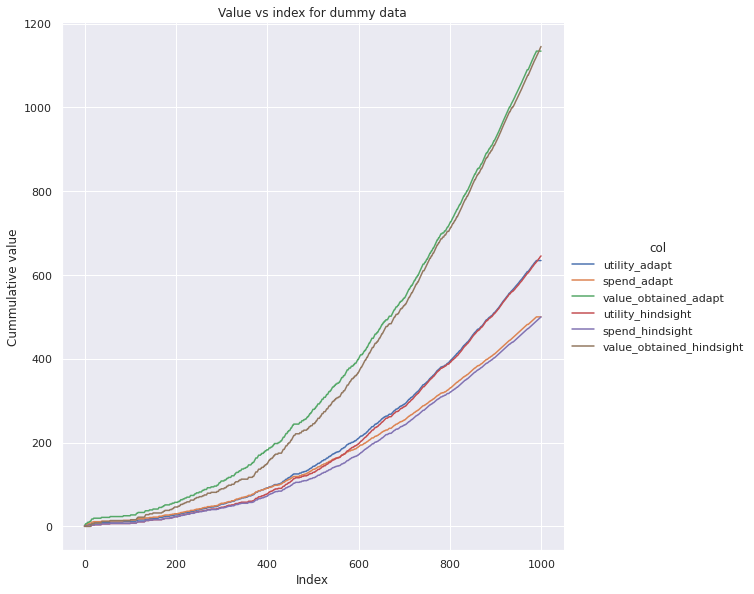

In [51]:
ax = sns.relplot(
    x="index",
    y="cumm_value",
    kind="line",
    hue = 'col',
    height=8,
    data=df_plot
    )
ax.set(xlabel='Index', ylabel='Cummulative value', title='Value vs index for dummy data')

In [17]:
df_regret = pd.DataFrame()
df_regret['regret'] = df_hindsight_cum['utility'] - df_adapt_cum['utility']
df_regret['regret'] =  df_regret['regret']/np.array(list(range(1, df_regret.shape[0]+1)))
ax = sns.relplot(
    kind="line",
    hue = 'col',
    height=8,
    data=df_regret
    )
ax.set(xlabel='Time', ylabel='Avg regret', title='Time vs Avg regret')

hindsight_total_val = df_hindsight_cum['utility'].iloc[-1]
var_total_val = df_adapt_cum['utility'].iloc[-1]
print("Percent regret variable: %f" % ((hindsight_total_val - var_total_val)*100/hindsight_total_val) )

ValueError: The following variable cannot be assigned with wide-form data: `hue`

# Learning OC for fixed data
We simulate the hindsight strategy to get the spend rate. Since just running the hindsight strategy once will lead to a non-continuous spen curve, to obtain a smooth version which we can use for in the adaptive pacing algorithm, we use subsampling. To learn the spend rate, we sample some of the rounds from the data, we scale the budget according to the sampling probability. We run the hindsight strategy with the scaled budget on the sampled rounds and we interpolate the spend for the rounds not sampled. We repeat this process multiple times and take the average to get the spend curve. Then we smooth the cruve by taking a rolling mean.

In [18]:
def approximate_spend_rate_from_dataset(dataset, sampling_probability, budget, num_trials, smoothing_window_size = 7):
    """
    Learns the spend rate (OC) from the dataset:
    
    Args:
        dataset: dataset for which we need to learn the OC (dataframe with value, competing_bid)
        sampling_probability: probability by which each round is sampled in a trial
        budget: budget of the dataset
        num_trials: Number of times the hindsight strategy is ran on a sampled set
        smoothing_window_size: rolling window size for rolling mean
        
    Returns:
        spend curve (OC) as numpy array with the same size as that of the number of rows in the dataset
        
    """
    total_impressions = dataset.shape[0]
    num_samples = int(total_impressions*sampling_probability)
    sampling_positions = (np.array(list(range(num_samples)))/sampling_probability).astype(int)
    scaled_budget = budget*sampling_probability
    sampled_spend = np.zeros(num_samples)
    for _i in range(num_trials):
        sampling_indices = sorted(np.random.choice(total_impressions, num_samples, replace=False))
        sampled_data = dataset.iloc[sampling_indices]
        dft = hindsight_strategy(sampled_data, scaled_budget)
        #print(dft['spend'].sum())
        sampled_spend += dft['spend'].values
    #return sampled_spend
    sampled_spend = sampled_spend/num_trials
    spend_curve = np.interp(list(range(total_impressions)), sampling_positions, sampled_spend)
    spend_cruve = average_spend_smoothing(spend_curve, smoothing_window_size)
    spend_sum = np.sum(spend_curve)
    if spend_sum != 0:
        spend_curve = (spend_curve/spend_sum)*budget
    return spend_curve

In [19]:
def average_spend_smoothing(target_spend, window_size = 7):
    """
    Rolling mean for the spend
    """
    if int(window_size)%2 != 1:
        raise Exception("window_size should be an odd number")
    padding_len = int((window_size-1)/2)
    left_padding = [target_spend[0]]* padding_len 
    right_padding = [target_spend[-1]]*padding_len 
    padded_target_spend = np.append(left_padding, target_spend)
    padded_target_spend = np.append(padded_target_spend,right_padding)
    target_spend_df = pd.DataFrame(padded_target_spend)
    return target_spend_df.rolling(window=window_size).mean().iloc[window_size-1:].values

## Linear OC

# Regret

## Value regret

In [34]:
def paced_regret(hindsight_df, pacing_df):
    """
    Final value regret. Returns percent regret measured with respect to the hindsight value
    """
    hindsight_total_val = hindsight_df['value_obtained'].sum()
    paced_total_val = pacing_df['value_obtained'].sum()
    return ((hindsight_total_val - paced_total_val)*100/hindsight_total_val) 

## Utility regret

In [35]:
def paced_regret_u(hindsight_df, pacing_df):
    """
    Final utility regret. Returns percent regret measured with respect to the hindsight value
    """
    hindsight_total_val = hindsight_df['utility'].sum()
    paced_total_val = pacing_df['utility'].sum()
    return ((hindsight_total_val - paced_total_val)*100/hindsight_total_val) 

Specify the OCs methods

- 'var' : Learned OC from data
- 'lin' : Linear OC (Also the Balseiro & Gur setting)
- 'mix_x' : Convex combination with x part linear and 1-x part learned

In [23]:
OCs = ['var','mix_0.5','lin']

In [24]:
transformed_df = changing_spend_dummy_dataset(1000)

Specify the budget fraction to specify the budget of our problem, a budget fraction 1 means we can buy all impressions, a ratio x means we have x fraction of the budget required to buy all fractions

In [25]:
budget_frac = 0.7

In [26]:
total_budget = transformed_df['competing_bid'].sum()
budget = total_budget*budget_frac

### Generate the spend rates (OC)

In [27]:
num_samples = transformed_df.shape[0]

Linear spend curve

In [28]:
target_lin_spend = linear_spend_rate(budget, num_samples)

Lerned spend curve

In [29]:
target_var_spend = approximate_spend_rate_from_dataset(dataset = transformed_df, sampling_probability =  0.2 , budget = budget, num_trials = 20)

<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']


### Run Hindsight strategy

In [30]:
campaign = '1'
paced_df = {}
paced_df[campaign] = {}
paced_df[campaign][budget_frac] = {}
data = transformed_df
paced_df[campaign][budget_frac]['hindsight'] = hindsight_strategy(data.copy(), budget = budget)

### Run adaptive pacing for all the OCs

In [36]:
learning_rate = 0.1
for OC in OCs:
    print(OC)
    if OC == 'var':
        adaptive_pacing_df = adaptive_pacing_bg(data.copy(), target_var_spend, learning_rate)
    elif OC == 'lin':
        adaptive_pacing_df = adaptive_pacing_bg(data.copy(), target_lin_spend, learning_rate)
    else:
        alpha = float(OC.split("_")[-1])
        # Mixed spend by taking convex combination
        mixed_spend = alpha * np.array(target_lin_spend) + (1-alpha)*np.array(target_var_spend)
        adaptive_pacing_df = adaptive_pacing_bg(data.copy(), mixed_spend, learning_rate)
    paced_df[campaign][budget_frac][OC] = adaptive_pacing_df.copy()

var
mix_0.5
lin


In [37]:
# Pickle dump the paced_df for future if needed
with open('./raw_data/paced_df_' + campaign + str(budget_frac), 'wb') as handle:
          pickle.dump(paced_df, handle, protocol=pickle.HIGHEST_PROTOCOL)

FileNotFoundError: [Errno 2] No such file or directory: './raw_data/paced_df_10.7'

### Plotting the data

Specify the cummulative colums to be plotted

In [64]:
#columns_plot = ['value_obtained', 'spend']

## Use utilty for the paper
columns_plot = ['utilility', 'spend']

In [39]:
df_cum = paced_df[campaign][budget_frac]['hindsight'][ columns_plot ].cumsum()
df_cum['index'] = df_cum.index
df_tidy =  pd.melt(df_cum, id_vars=['index'], var_name='cols', value_name = 'cumm_value')
df_tidy['OC'] = 'hindsight'
df_plot = df_tidy.copy()
for OC in OCs:
    df_cum = paced_df[campaign][budget_frac][OC][ columns_plot ].cumsum()
    df_cum['index'] = df_cum.index
    df_tidy =  pd.melt(df_cum, id_vars=['index'], var_name='cols', value_name = 'cumm_value')
    df_tidy['OC'] = OC
    df_plot = pd.concat([df_plot, df_tidy])

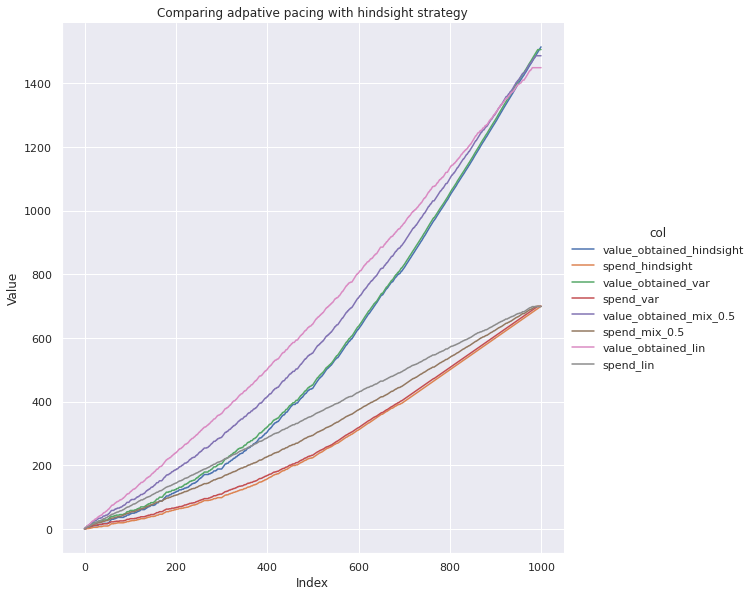

In [40]:
df_plot['col'] = df_plot[['cols', 'OC']].apply(lambda x: '_'.join(x), axis = 1)

ax = sns.relplot(
x ='index',
y ='cumm_value',
kind ='line',
hue = 'col',
height = 8,
data = df_plot
)
ax.set(xlabel='Index', ylabel='Value', title='Comparing adpative pacing with hindsight strategy')

### Plotting average regret

Select the variable for regret

In [41]:
regret_variable = 'value_obtained'
# Use utility for the paper
#regret_variable = 'utility'

if regret_variable=='value_obtained':
    reg_fun = paced_regret
elif regret_variable=='utility':
    reg_fun = paced_regret_u

Calculate average regret for each OC

In [42]:
df_hindsight_cum = paced_df[campaign][budget_frac]['hindsight'][regret_variable].cumsum()
df_regret = pd.DataFrame()
for OC in OCs:
    df_adapt_cum = paced_df[campaign][budget_frac][OC][regret_variable].cumsum()
    #print(df_adapt_cum)
    df_regret[OC] = df_hindsight_cum - df_adapt_cum
    df_regret[OC] =  df_regret[OC]/np.array(list(range(1, df_regret.shape[0]+1)))
    
    print("Percentage regret for %s is %f"%(OC, reg_fun(paced_df[campaign][budget_frac]['hindsight'], paced_df[campaign][budget_frac][OC])  ))

Percentage regret for var is 0.568865
Percentage regret for mix_0.5 is 1.846704
Percentage regret for lin is 4.322444


Tidy the dataframe and plot

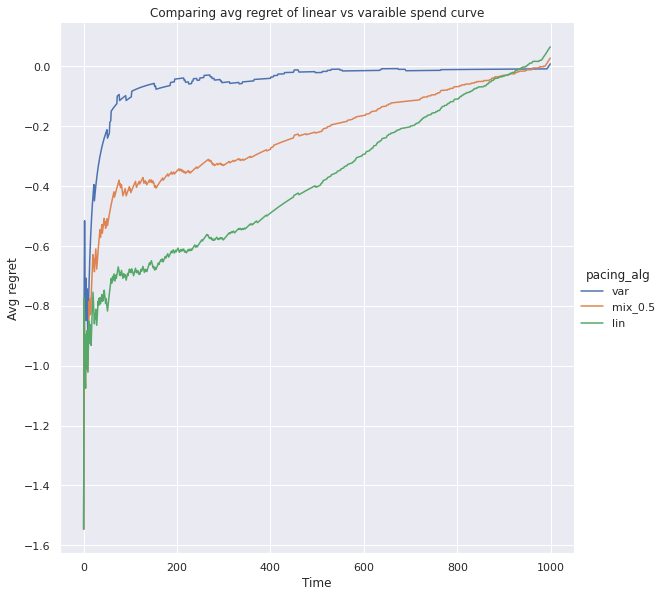

In [43]:
df_regret['index'] = df_regret.index
df_regret_tidy =  pd.melt(df_regret, id_vars=['index'], var_name='pacing_alg', value_name = 'avg_regret')

ax = sns.relplot(
kind="line",
x="index",
y="avg_regret",
hue = 'pacing_alg',
height=8,
data=df_regret_tidy
)
ax.set(xlabel='Time', ylabel='Avg regret', title='Comparing avg regret of linear vs varaible spend curve')

In [137]:
df = moving_uniform(10, 100)

In [92]:
df['bang_per_buck'] = df['value']/df['competing_bid']

In [101]:
bang_per_buck_cdf = ECDF(df['bang_per_buck'])

In [130]:
x = smallest_x_with_cdf(bang_per_buck_cdf, 0.233)

In [148]:
estimate_spend_rate(df_samples = df, budget = 50, num_episodes = 10, T = 10)

array([0.02004008, 0.02004008, 0.02004008, 0.02004008, 0.02004008,
       0.02004008, 0.02004008, 0.02004008, 0.02004008, 0.02004008,
       0.1503006 , 0.1503006 , 0.1503006 , 0.1503006 , 0.1503006 ,
       0.1503006 , 0.1503006 , 0.1503006 , 0.1503006 , 0.1503006 ,
       0.27054108, 0.27054108, 0.27054108, 0.27054108, 0.27054108,
       0.27054108, 0.27054108, 0.27054108, 0.27054108, 0.27054108,
       0.37074148, 0.37074148, 0.37074148, 0.37074148, 0.37074148,
       0.37074148, 0.37074148, 0.37074148, 0.37074148, 0.37074148,
       0.501002  , 0.501002  , 0.501002  , 0.501002  , 0.501002  ,
       0.501002  , 0.501002  , 0.501002  , 0.501002  , 0.501002  ,
       0.501002  , 0.501002  , 0.501002  , 0.501002  , 0.501002  ,
       0.501002  , 0.501002  , 0.501002  , 0.501002  , 0.501002  ,
       0.61122244, 0.61122244, 0.61122244, 0.61122244, 0.61122244,
       0.61122244, 0.61122244, 0.61122244, 0.61122244, 0.61122244,
       0.78156313, 0.78156313, 0.78156313, 0.78156313, 0.78156

# Experiment for papers, fixed price = 1

In [63]:
learning_rate = 0.1

In [54]:
num_episodes = 10
T = 1000
training_samples_per_episode = 10000

In [71]:
budget_frac = 0.5
budget = T*num_episodes*budget_frac

In [56]:
data = moving_uniform(num_episodes, T)
training_data = moving_uniform(num_episodes, training_samples_per_episode)

In [72]:
data = moving_normal(num_episodes, T)
training_data = moving_normal(num_episodes, training_samples_per_episode)

In [73]:
target_dist_spend = estimate_spend_rate(df_samples = training_data, budget = budget, num_episodes = num_episodes, T = T)

In [74]:
target_lin_spend = linear_spend_rate(budget, num_episodes*T)

In [527]:
# Learn the spend rate for this dummy data
target_var_spend = approximate_spend_rate(lambda x : moving_uniform (num_episodes, int(x/num_episodes)), budget = budget, num_samples = num_episodes*T, num_trials = 5)



In [75]:
paced_df = {}
OCs =['truthful','lin','dist']

In [76]:
# Running the hindsight algorithm
paced_df['hindsight'] = hindsight_strategy(data, budget = budget)

In [82]:
for OC in OCs:
    print(OC)
    if OC == 'var':
        adaptive_pacing_df = adaptive_pacing_bg(data.copy(), target_var_spend, learning_rate)
    elif OC == 'lin':
        adaptive_pacing_df = adaptive_pacing_bg(data.copy(), target_lin_spend, learning_rate)
    elif OC == 'dist':
        adaptive_pacing_df = adaptive_pacing_bg(data.copy(), target_dist_spend, learning_rate)
    elif OC == 'e_hin':
        adaptive_pacing_df = episodic_hindsight_strategy(data.copy(), target_dist_spend, num_episodes, T)
    elif OC == 'truthful':
        adaptive_pacing_df = truthful_bidding(data, budget = budget)
    else:
        alpha = float(OC.split("_")[-1])
        # Mixed spend by taking convex combination
        mixed_spend = alpha * np.array(target_lin_spend) + (1-alpha)*np.array(target_var_spend)
        adaptive_pacing_df = adaptive_pacing_bg(data.copy(), mixed_spend, learning_rate)
    paced_df[OC] = adaptive_pacing_df.copy()

truthful
dist
lin


In [83]:
OCs = { 'dist', 'lin', 'truthful'}

In [67]:
columns_plot = ['utility', 'spend']

In [85]:
df_cum = paced_df['hindsight'][ columns_plot ].cumsum()
df_cum['index'] = df_cum.index
df_tidy =  pd.melt(df_cum, id_vars=['index'], var_name='cols', value_name = 'cumm_value')
df_tidy['OC'] = 'hindsight'
df_plot = df_tidy.copy()
for OC in OCs:
    df_cum = paced_df[OC][ columns_plot ].cumsum()
    df_cum['index'] = df_cum.index
    df_tidy =  pd.melt(df_cum, id_vars=['index'], var_name='cols', value_name = 'cumm_value')
    df_tidy['OC'] = OC
    df_plot = pd.concat([df_plot, df_tidy])

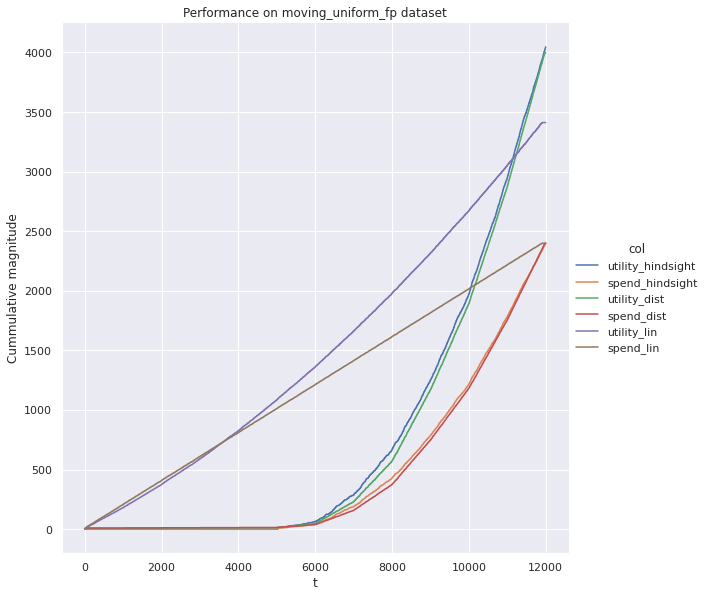

In [285]:
df_plot['col'] = df_plot[['cols', 'OC']].apply(lambda x: '_'.join(x), axis = 1)

ax = sns.relplot(
x ='index',
y ='cumm_value',
kind ='line',
hue = 'col',
height = 8,
data = df_plot
)
ax.set(xlabel='t', ylabel='Cummulative magnitude', title='Performance on moving_uniform_fp dataset')

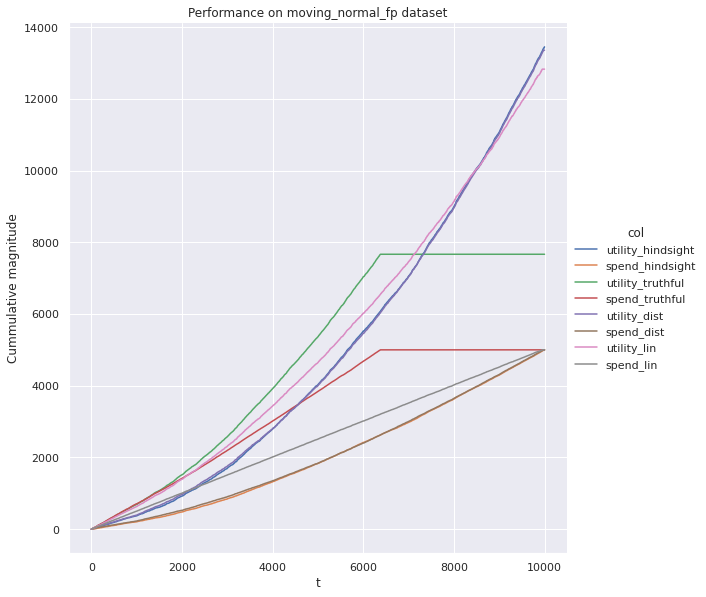

In [86]:
df_plot['col'] = df_plot[['cols', 'OC']].apply(lambda x: '_'.join(x), axis = 1)

ax = sns.relplot(
x ='index',
y ='cumm_value',
kind ='line',
hue = 'col',
height = 8,
data = df_plot
)
ax.set(xlabel='t', ylabel='Cummulative magnitude', title='Performance on moving_normal_fp dataset')

In [65]:
regret_variable = 'utility'
# Use utility for the paper
#regret_variable = 'utility'

if regret_variable=='value_obtained':
    reg_fun = paced_regret
elif regret_variable=='utility':
    reg_fun = paced_regret_u

In [305]:
df_hindsight_cum = paced_df['hindsight'][regret_variable].cumsum()
df_regret = pd.DataFrame()
for OC in OCs:
    df_adapt_cum = paced_df[OC][regret_variable].cumsum()
    #print(df_adapt_cum)
    df_regret[OC] = df_hindsight_cum - df_adapt_cum
    df_regret[OC] =  df_regret[OC]/np.array(list(range(1, df_regret.shape[0]+1)))
    
    print("Percentage regret for %s is %f"%(OC, reg_fun(paced_df['hindsight'], paced_df[OC])  ))
    
    

Percentage regret for dist is 0.616021
Percentage regret for lin is 4.528732


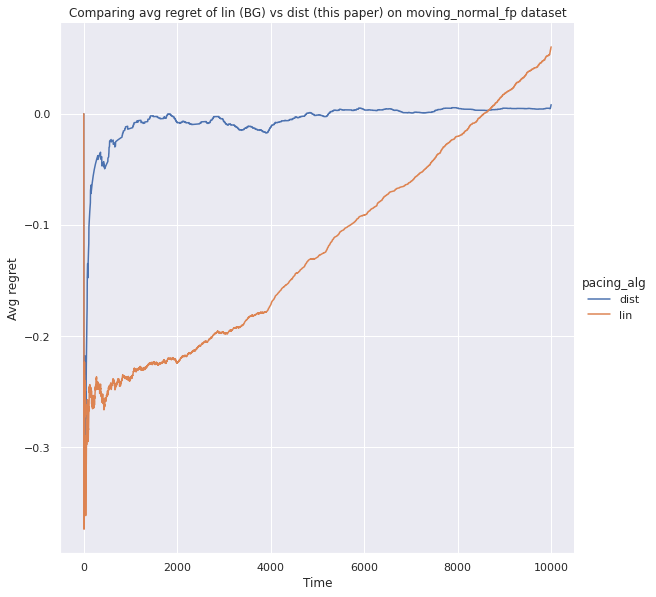

In [308]:
df_regret['index'] = df_regret.index
df_regret_tidy =  pd.melt(df_regret, id_vars=['index'], var_name='pacing_alg', value_name = 'avg_regret')

ax = sns.relplot(
kind="line",
x="index",
y="avg_regret",
hue = 'pacing_alg',
height=8,
data=df_regret_tidy
)
ax.set(xlabel='Time', ylabel='Avg regret', title='Comparing avg regret of lin (BG) vs dist (this paper) on moving_normal_fp dataset')

In [472]:
n = [1,10,20,50,100,200,300,1000]
#n = [500,1000,3000]

In [473]:
paced_df = {}
num_repeat = 5
gamma = {}
for training_samples_per_episode in n:
    gamma[training_samples_per_episode] = []
for exp_counter in range(num_repeat):
    data = moving_normal(num_episodes, T)
    OCs =['e_hin']
    paced_df['hindsight'] = hindsight_strategy(data, budget = budget)
    for training_samples_per_episode in n:
        training_data = moving_normal(num_episodes, training_samples_per_episode)
        target_dist_spend = estimate_spend_rate(df_samples = training_data, budget = budget, num_episodes = num_episodes, T = T)
        for OC in OCs:
            if OC == 'var':
                adaptive_pacing_df = adaptive_pacing_bg(data.copy(), target_var_spend, learning_rate)
            elif OC == 'lin':
                adaptive_pacing_df = adaptive_pacing_bg(data.copy(), target_lin_spend, learning_rate)
            elif OC == 'dist':
                adaptive_pacing_df = adaptive_pacing_bg(data.copy(), target_dist_spend, learning_rate)
            elif OC == 'e_hin':
                adaptive_pacing_df = episodic_hindsight_strategy(data.copy(), target_dist_spend, num_episodes, T)
            else:
                alpha = float(OC.split("_")[-1])
                # Mixed spend by taking convex combination
                mixed_spend = alpha * np.array(target_lin_spend) + (1-alpha)*np.array(target_var_spend)
                adaptive_pacing_df = adaptive_pacing_bg(data.copy(), mixed_spend, learning_rate)
            paced_df[OC] = adaptive_pacing_df.copy()
        reg_fun = paced_regret_u
        df_hindsight_cum = paced_df['hindsight'][regret_variable].cumsum()
        df_regret = pd.DataFrame()
        for OC in OCs:
            df_adapt_cum = paced_df[OC][regret_variable].cumsum()
            #print(df_adapt_cum)
            df_regret[OC] = df_hindsight_cum - df_adapt_cum
            df_regret[OC] =  df_regret[OC]/np.array(list(range(1, df_regret.shape[0]+1)))
            gamma[training_samples_per_episode] = gamma[training_samples_per_episode] + [reg_fun(paced_df['hindsight'], paced_df[OC])/100]

for training_samples_per_episode in n:
    gamma[training_samples_per_episode] = np.mean(gamma[training_samples_per_episode])
  

<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

In [315]:
gamma

{1: 0.19432007114997635,
 10: 0.011403199841857378,
 20: 0.01113516964569127,
 50: 0.003992972876479579,
 100: 0.0024633942118220493,
 200: 0.0014251087766229981,
 300: 0.0011694073493102284,
 1000: 0.0005023733777824381}

Text(0.5, 1.0, 'Regret of episodic hindight on moving_uniform_fp')

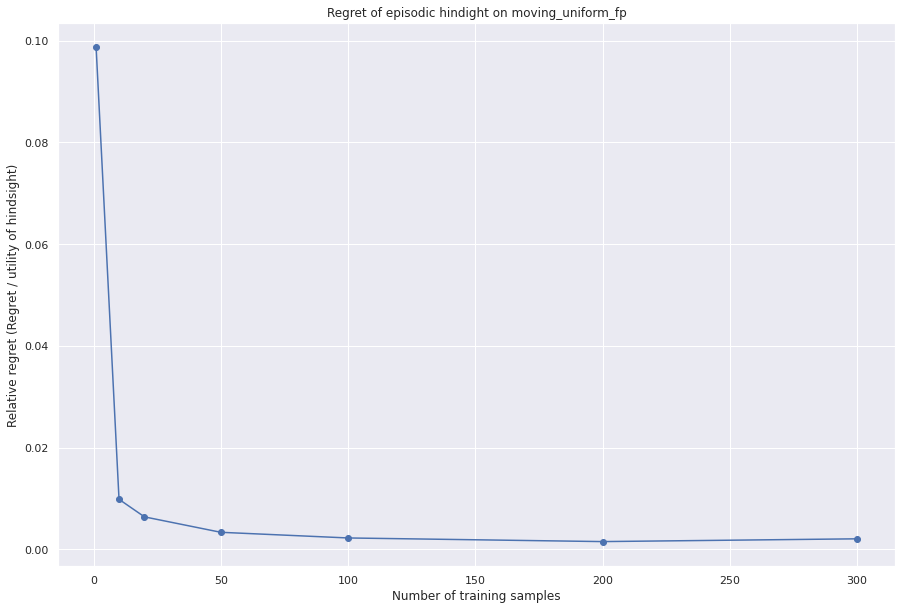

In [311]:
#lists = sorted(gamma.items()) # sorted by key, return a list of tuples
#x, y = zip(*lists)
plt.plot(x, y,marker="o")
plt.xlabel('Number of training samples')
plt.ylabel('Relative regret (Regret / utility of hindsight)')
plt.title('Regret of episodic hindight on moving_uniform_fp')

Text(0.5, 1.0, 'Regret of episodic hindight on moving_normal_fp')

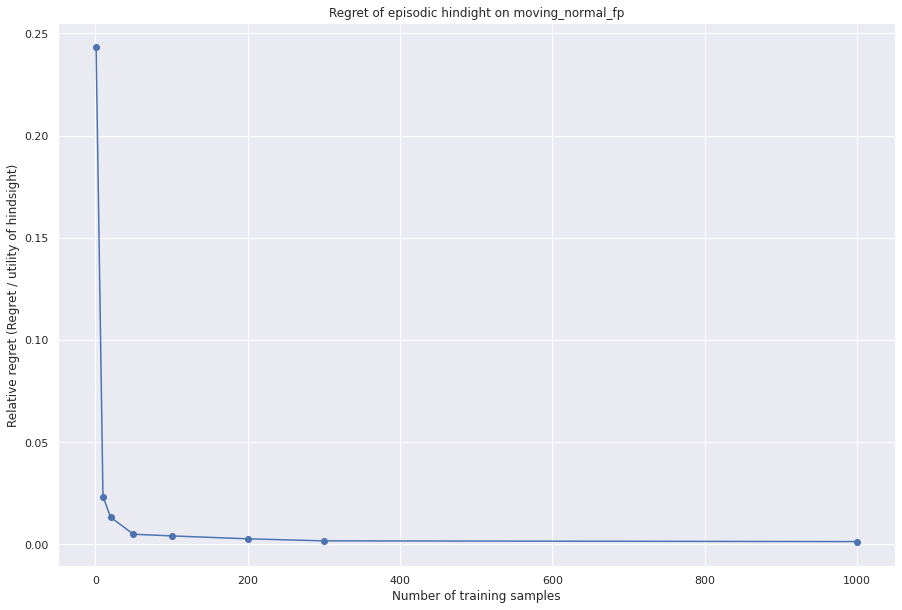

In [474]:
lists = sorted(gamma.items()) # sorted by key, return a list of tuples
x, y = zip(*lists)
plt.plot(x, y,marker="o")
plt.xlabel('Number of training samples')
plt.ylabel('Relative regret (Regret / utility of hindsight)')
plt.title('Regret of episodic hindight on moving_normal_fp')

## Budget_frac vs ratio of utility plots

## Changing uniform

In [25]:
budget_fracs = np.random (0.1,1.5, 0.05)

In [26]:
budget_fracs

array([0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 ,
       0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  , 1.05, 1.1 , 1.15,
       1.2 , 1.25, 1.3 , 1.35, 1.4 , 1.45])

In [437]:
val_mean = uniform_samples(num_episodes, low=2, high=5)
val_mean.sort()
price_mean = uniform_samples (num_episodes, low=2, high = 4))
price_mean[::-1].sort()
print(val_mean, price_mean)

[2.03018603 2.47006102 2.53493175 3.07104313 3.28625485 3.36718074
 3.381394   3.45238388 3.75963265 4.84485976] [1.91443854 1.87089678 1.86067299 1.80204113 1.74477897 1.58500308
 1.56538144 1.51848214 1.4886464  1.46668666]


In [ ]:
lval_mean = uniform_samples(num_episodes, low=0.6, high=1.5)
#lval_mean[::-1].sort()
lval_std = np.sqrt(uniform_samples (num_episodes, low=.04, high = 0.07))
#lval_std.sort()
print(lval_mean, lval_std)

In [682]:
num_competition = 10
lognormal_pricemeans = np.random.uniform(-0.2, 0.3, (num_episodes, num_competition))
lognormal_valmeans = uniform_samples(num_episodes, low=0.6, high=1.5)
#lognormal_valmeans.sort()
pricestd =  0.8
valstd = 0.25

In [657]:
pprint(lognormal_pricemeans)
pprint(lognormal_valmeans)

[[-0.09,-0.17,-0.18,-0.03,-0.03,-0.12, 0.08, 0.09, 0.14, 0.19],
 [ 0.2 , 0.18, 0.12, 0.02, 0.04, 0.13, 0.14,-0.06, 0.28,-0.08],
 [ 0.21,-0.19, 0.03,-0.16, 0.18, 0.17,-0.09,-0.08,-0.01, 0.09],
 [-0.13, 0.26,-0.2 , 0.07, 0.01, 0.19,-0.07, 0.23,-0.05,-0.02],
 [-0.19,-0.04, 0.18,-0.05,-0.08, 0.18, 0.01, 0.16, 0.3 , 0.11],
 [ 0.27, 0.07, 0.26,-0.11, 0.21,-0.15,-0.06,-0.14, 0.12, 0.21],
 [ 0.09,-0.11, 0.12, 0.22, 0.1 , 0.24,-0.18,-0.06, 0.15,-0.07],
 [ 0.25, 0.08,-0.14, 0.23,-0.11, 0.09, 0.16, 0.3 ,-0.  , 0.12],
 [-0.02, 0.17,-0.1 ,-0.08, 0.3 ,-0.03, 0.06, 0.2 , 0.09,-0.07],
 [-0.03, 0.04, 0.15, 0.02,-0.1 , 0.22, 0.26, 0.13, 0.09, 0.04]]
[0.69,0.79,0.81,0.82,0.87,0.93,1.  ,1.2 ,1.21,1.25]


In [683]:
pprint(lognormal_pricemeans)
pprint(lognormal_valmeans)


[[ 0.08, 0.03, 0.14,-0.2 ,-0.05,-0.18, 0.14, 0.22, 0.12,-0.03],
 [-0.1 , 0.11,-0.19,-0.16, 0.12, 0.15, 0.24,-0.13,-0.09, 0.3 ],
 [-0.12, 0.25, 0.07, 0.16, 0.06, 0.11, 0.11,-0.03, 0.24,-0.07],
 [ 0.27, 0.2 , 0.1 , 0.27, 0.22, 0.14, 0.16, 0.18,-0.15,-0.16],
 [ 0.03, 0.05, 0.06, 0.28,-0.09, 0.04,-0.04,-0.11, 0.19, 0.2 ],
 [-0.01,-0.17, 0.19, 0.14,-0.18,-0.01, 0.05, 0.18,-0.14, 0.14],
 [ 0.04,-0.02, 0.17, 0.28, 0.29, 0.21, 0.28, 0.27,-0.09,-0.12],
 [-0.19, 0.26,-0.17, 0.  ,-0.14, 0.22, 0.23, 0.09,-0.13,-0.1 ],
 [-0.11, 0.1 , 0.18,-0.18, 0.3 ,-0.  ,-0.12, 0.11,-0.05, 0.12],
 [ 0.07, 0.06,-0.18,-0.15, 0.09,-0.03,-0.11, 0.16, 0.1 ,-0.1 ]]
[0.86,1.2 ,1.05,0.96,1.  ,0.77,1.45,1.3 ,1.31,0.86]


In [ ]:
lval_mean = np.normal
#lval_mean[::-1].sort()
lval_std = np.sqrt(uniform_samples (num_episodes, low=.04, high = 0.07))
#lval_std.sort()
print(lval_mean, lval_std)

In [471]:

[0.73936311 0.7789638  0.63079366 1.4722515  1.41175179 1.43747766
 0.96815352 0.67714056 1.22222672 0.99699688]
[0.20170068 0.22812122 0.25120864 0.24029813 0.23502862 0.26100574
 0.25993792 0.21967203 0.2568908  0.24477579]

SyntaxError: invalid syntax (<ipython-input-471-bbbe82eb0a0c>, line 1)

In [222]:
df_utility_res = {}

In [88]:
datasets = ['uniform_v_fix_p' ,'normal_v_fix_p','lognorm_v_fix_p', 'uniform_v_normal_p', 'normal_v_normal_p', 'lognorm_v_maxlognorm_p'] 
dataset = 'uniform_v_fix_p'
spend_rate_estimation_oracle = estimate_spend_rate_cp
if dataset == 'uniform_v_fix_p':
    data_oracle = moving_uniform
    spend_rate_estimation_oracle = estimate_spend_rate
elif dataset == 'normal_v_fix_p':
    data_oracle = moving_normal
    spend_rate_estimation_oracle = estimate_spend_rate
elif dataset == 'lognorm_v_fix_p':
    data_oracle = lambda num_episodes, T: lognorm_val_fp(num_episodes, T, lval_mean, lval_std)
    print(lval_mean)
    spend_rate_estimation_oracle = estimate_spend_rate
elif dataset == 'uniform_v_normal_p':
    data_oracle = uniform_val_normal_price
elif dataset == 'normal_v_normal_p':
    data_oracle = lambda num_episodes, T: normal_val_normal_price(num_episodes, T, val_mean, price_mean)
elif dataset == 'lognorm_v_maxlognorm_p':
    data_oracle = lambda num_episodes, T: lognorm_val_maxlognorm_price(num_episodes, T, lognormal_valmeans, lognormal_pricemeans, valstd, pricestd)


In [89]:
df_utility_res[dataset] = pd.DataFrame (columns = ['utility', 'utility_h', 'budget_frac', 'OC']) 

In [90]:
num_episodes = 10
T = 100
training_samples_per_episode = 1000

In [91]:
OCs =['truthful','lin','dist', 'fixed_p']
OCs =['dist', 'fixed_p']
OCs =['truthful','lin','dist']

In [92]:
num_exp = 1
learning_rate = 0.1

0
budget_frac = 0.460190
[0.019 0.114 0.211 0.338 0.376 0.531 0.603 0.701 0.798 0.91 ]
0.5617899134017265


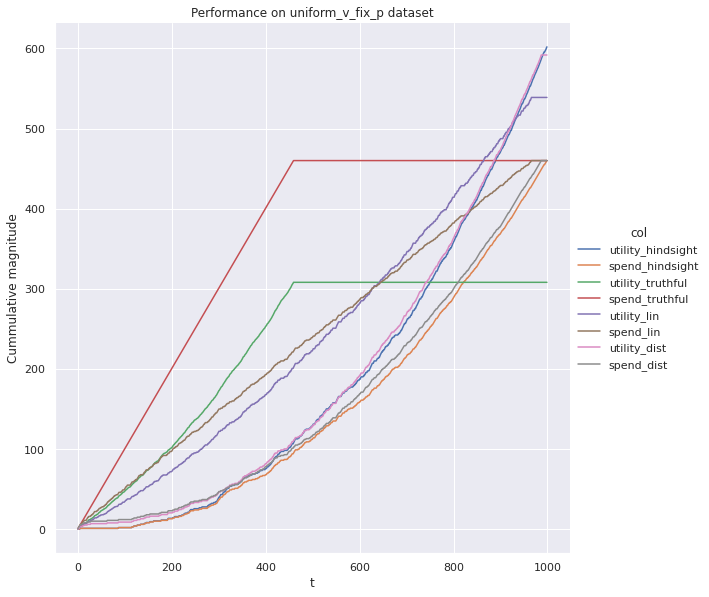

In [93]:
for exp_c in range(num_exp):
    if exp_c%5==0:
        print(exp_c)
    data = data_oracle(num_episodes, T)
    training_data = data_oracle(num_episodes, training_samples_per_episode)
    budget_frac = np.random.uniform(0.3,0.5)
    budget_total = data[data['value'] > data['competing_bid'] ]['competing_bid'].sum()
    print("budget_frac = %f"%budget_frac)
    budget = budget_total*budget_frac
    target_dist_spend = spend_rate_estimation_oracle(df_samples = training_data, budget = budget, num_episodes = num_episodes, T = T)
    #fixed_pace = estimate_pacing_multiplier_gd(df = training_data, budget = budget, num_episodes = num_episodes, T = T)
    print(fixed_pace)
    target_lin_spend = linear_spend_rate(budget, num_episodes*T)
    paced_df = {}
    paced_df['hindsight'] = hindsight_strategy(data, budget = budget)
    utility_h = paced_df['hindsight']['utility'].sum()
    for OC in OCs:
        #print(OC)
        if OC == 'var':
            adaptive_pacing_df = adaptive_pacing_bg(data.copy(), target_var_spend, learning_rate)
        elif OC == 'lin':
            adaptive_pacing_df = adaptive_pacing_bg(data.copy(), target_lin_spend, learning_rate)
        elif OC == 'dist':
            adaptive_pacing_df = adaptive_pacing_bg(data.copy(), target_dist_spend, learning_rate)
        elif OC == 'e_hin':
            adaptive_pacing_df = episodic_hindsight_strategy(data.copy(), target_dist_spend, num_episodes, T)
        elif OC == 'truthful':
            adaptive_pacing_df = truthful_bidding(data.copy(), budget = budget)
        if OC == 'fixed_p':
            adaptive_pacing_df = fixed_pacing_strategy(data.copy(), budget, fixed_pace, num_episodes, T)
            
        paced_df[OC] = adaptive_pacing_df.copy()
        row = {'utility' : adaptive_pacing_df["utility"].sum(), 'utility_h' : utility_h, 'budget_frac' : budget_frac, 'OC' : OC}
        df_utility_res[dataset] = df_utility_res[dataset].append(row,ignore_index=True)
    df_cum = paced_df['hindsight'][ columns_plot ].cumsum()
    df_cum['index'] = df_cum.index
    df_tidy =  pd.melt(df_cum, id_vars=['index'], var_name='cols', value_name = 'cumm_value')
    df_tidy['OC'] = 'hindsight'
    df_plot = df_tidy.copy()
    for OC in OCs:
        df_cum = paced_df[OC][ columns_plot ].cumsum()
        df_cum['index'] = df_cum.index
        df_tidy =  pd.melt(df_cum, id_vars=['index'], var_name='cols', value_name = 'cumm_value')
        df_tidy['OC'] = OC
        df_plot = pd.concat([df_plot, df_tidy])
    df_plot['col'] = df_plot[['cols', 'OC']].apply(lambda x: '_'.join(x), axis = 1)

    ax = sns.relplot(
    x ='index',
    y ='cumm_value',
    kind ='line',
    hue = 'col',
    height = 8,
    data = df_plot
    )
    ax.set(xlabel='t', ylabel='Cummulative magnitude', title=('Performance on ' + dataset + ' dataset'))

In [913]:
df_utility_res[dataset]['fractional_ut'] = df_utility_res[dataset]['utility']/df_utility_res[dataset]['utility_h']

In [717]:
addr = '/home/ubuntu/work/pacing/data/' + dataset +'.pkl'
df_utility_res[dataset].to_pickle(addr)

In [48]:
plot_base = '/home/ubuntu/work/pacing/data/plots/'

In [ ]:
df_utility_res[dataset]  = pd.read_pickle('/home/ubuntu/work/pacing/data/' + dataset +'.pkl')

In [638]:
df_utility_res[dataset] = df_utility_res[dataset][:-60]
df_utility_res[dataset].shape

(479, 5)

<ipython-input-736-e91c861c1c54>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Algorithm'][i] = mapping[ df['OC'][i]]


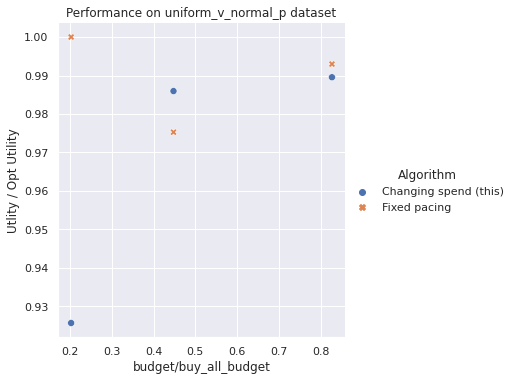

In [914]:
ax = sns.relplot(
x ='budget_frac',
y ='fractional_ut',
kind = 'scatter',
hue = 'Algorithm',
style="Algorithm",
height = 5,
data = change_OC(df_utility_res[dataset]),
s= 50
)
ax.set(xlabel='budget/buy_all_budget' , ylabel='Utlity / Opt Utility', title=('Performance on ' + dataset + ' dataset'))
plt.savefig(plot_base + dataset + ".eps",dpi=300, bbox_inches='tight')




/home/ubuntu/work/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/home/ubuntu/work/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/home/ubuntu/work/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexin

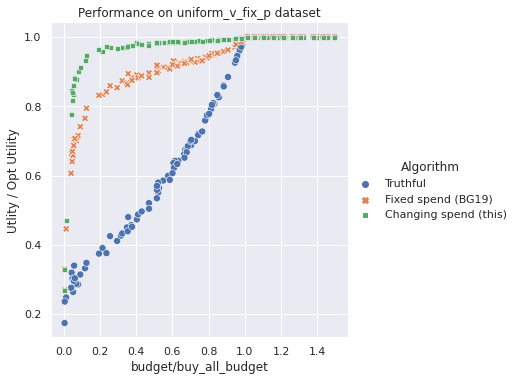

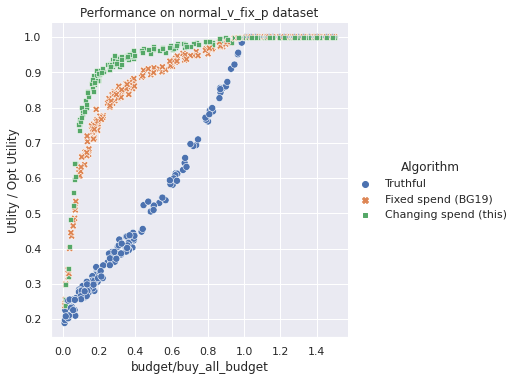

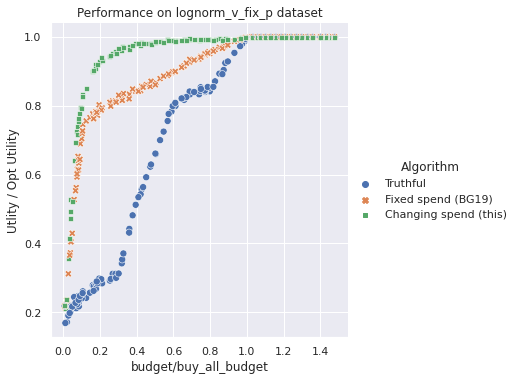

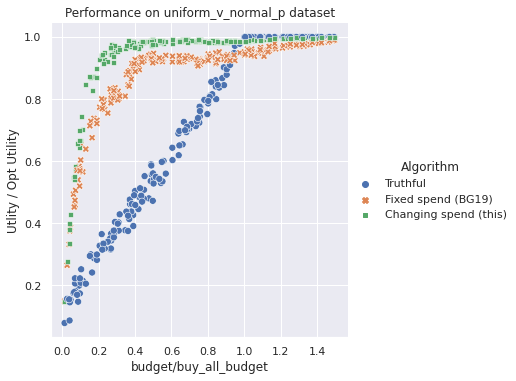

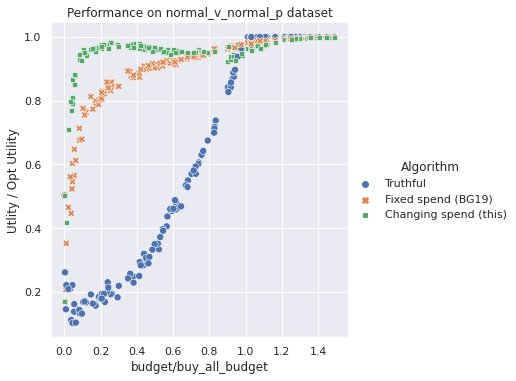

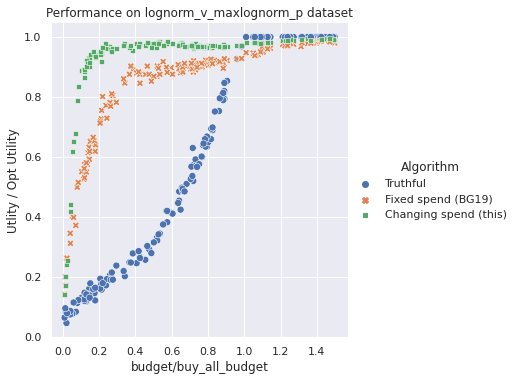

In [49]:
for dataset in datasets:
    df_utility_res[dataset]  = pd.read_pickle('/home/ubuntu/work/pacing/data/' + dataset +'.pkl')
    ax = sns.relplot(
    x ='budget_frac',
    y ='fractional_ut',
    kind = 'scatter',
    hue = 'Algorithm',
    style="Algorithm",
    height = 5,
    data = change_OC(df_utility_res[dataset]),
    s= 50,
    legend = True
    )
    ax.set(xlabel='budget/buy_all_budget' , ylabel='Utlity / Opt Utility', title=('Performance on ' + dataset + ' dataset'))
    plt.savefig(plot_base + dataset + ".eps",dpi=300, bbox_inches='tight')

In [3]:
df_utility_res = {}

In [45]:
all_datasets_res = pd.DataFrame()
#pd.DataFrame (columns = ['utility', 'utility_h', 'budget_frac', 'OC']) 
for dataset in datasets:
    df_utility_res[dataset]  = pd.read_pickle('/home/ubuntu/work/pacing/data/' + dataset +'.pkl')
    df_temp = df_utility_res[dataset]
    df_temp['dataset'] = dataset
    all_datasets_res = pd.concat([all_datasets_res, df_temp])
all_datasets_res = change_OC(all_datasets_res)

/home/ubuntu/work/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


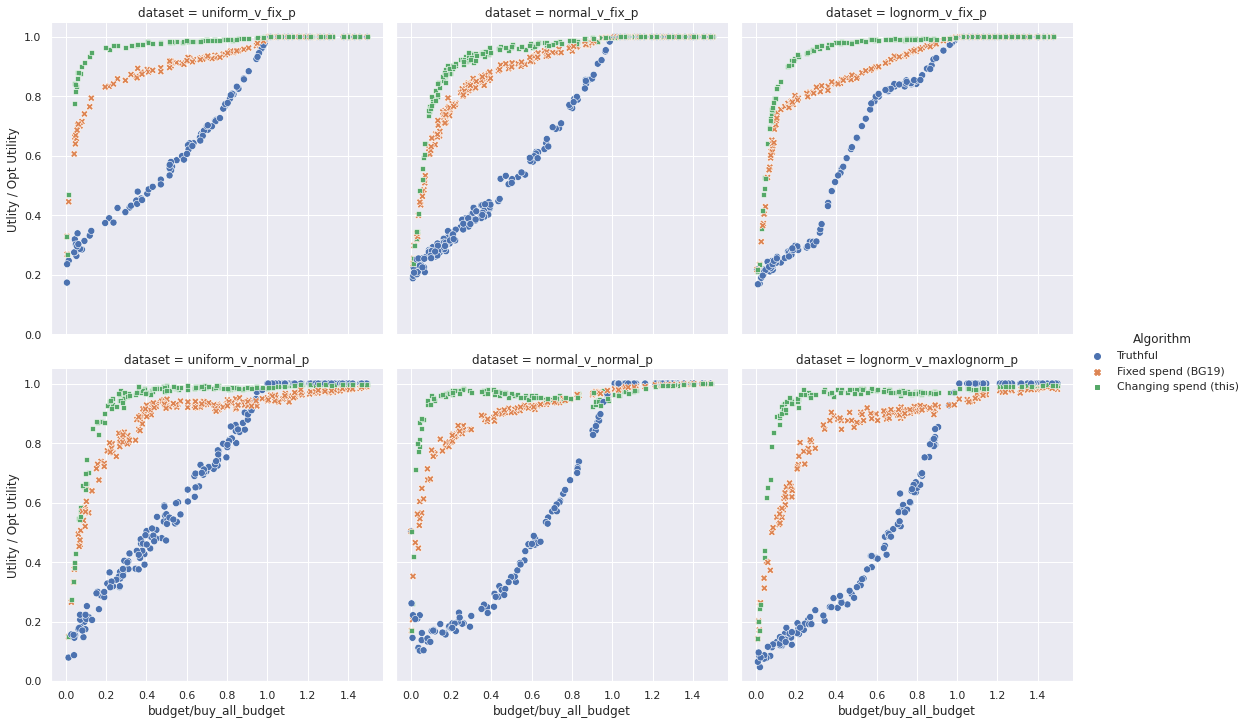

In [55]:
ax = sns.relplot(
    x ='budget_frac',
    y ='fractional_ut',
    kind = 'scatter',
    hue = 'Algorithm',
    style="Algorithm",
    col = "dataset",
    height = 5,
    col_wrap=3,
    data = all_datasets_res,
    s= 50,
    legend = True
    )
ax.set(xlabel='budget/buy_all_budget' , ylabel='Utlity / Opt Utility')
plt.savefig(plot_base + "all_dataset" + ".eps",dpi=300, bbox_inches='tight')

In [36]:
ax = sns.relplot(
x ='budget_frac',
y ='fractional_ut',
kind = 'scatter',
hue = 'Algorithm',
style="Algorithm",
height = 5,
data = change_OC(df_utility_res),
s= 50
)
ax.set(xlabel='budget/buy_all_budget' , ylabel='Utlity / Opt Utility', title='Performance on moving_normal_fp dataset')

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [123]:
df_utility_res[df_utility_res['OC']=='truthful']

,utility,utility_h,budget_frac,OC,fractional_ut
0,54.682917,184.084174,0.01,truthful,0.297054
3,570.281556,1798.151740,0.11,truthful,0.317149
6,1169.688874,3184.652295,0.21,truthful,0.367289
9,1876.577287,4415.494365,0.31,truthful,0.424998
12,2684.584634,5514.161568,0.41,truthful,0.486853
15,3597.863780,6499.176712,0.51,truthful,0.553588
18,4606.971922,7385.311901,0.61,truthful,0.623802
21,5725.780121,8160.659963,0.71,truthful,0.701632
23,509.828936,1648.956814,0.10,truthful,0.309183
26,1101.795835,3053.681275,0.20,truthful,0.360809


# Experiment for papers, changing price

## Uniform value, normal price

In [429]:
num_episodes = 10
T = 1000
training_samples_per_episode = 10000

In [430]:
data = uniform_val_normal_price(num_episodes, T)
training_data = uniform_val_normal_price(num_episodes, training_samples_per_episode)

In [457]:
budget_frac = 0.2
budget = data['competing_bid'].sum()*budget_frac

In [458]:
target_dist_spend = estimate_spend_rate_cp(df_samples = training_data, budget = budget, num_episodes = num_episodes, T = T)


<ipython-input-364-677bbdd91b18>:3: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return integrate.quad(spend_p, 0, h)[0]


In [459]:
target_lin_spend = linear_spend_rate(budget, num_episodes*T)

In [460]:
target_var_spend = approximate_spend_rate(lambda x : uniform_val_normal_price (num_episodes, int(x/num_episodes)), budget = budget, num_samples = num_episodes*T, num_trials = 10)


In [461]:
paced_df = {}
OCs =['e_hin','lin', 'var', 'dist']

In [462]:
# Running the hindsight algorithm
paced_df['hindsight'] = hindsight_strategy(data, budget = budget)

In [463]:
for OC in OCs:
    print(OC)
    if OC == 'var':
        adaptive_pacing_df = adaptive_pacing_bg(data.copy(), target_var_spend, learning_rate)
    elif OC == 'lin':
        adaptive_pacing_df = adaptive_pacing_bg(data.copy(), target_lin_spend, learning_rate)
    elif OC == 'dist':
        adaptive_pacing_df = adaptive_pacing_bg(data.copy(), target_dist_spend, learning_rate)
    elif OC == 'e_hin':
        adaptive_pacing_df = episodic_hindsight_strategy(data.copy(), target_dist_spend, num_episodes, T)
    else:
        alpha = float(OC.split("_")[-1])
        # Mixed spend by taking convex combination
        mixed_spend = alpha * np.array(target_lin_spend) + (1-alpha)*np.array(target_var_spend)
        adaptive_pacing_df = adaptive_pacing_bg(data.copy(), mixed_spend, learning_rate)
    paced_df[OC] = adaptive_pacing_df.copy()

e_hin


<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

lin
var
dist


In [464]:
OCs = { 'lin', 'dist'}
columns_plot = ['utility', 'spend']
df_cum = paced_df['hindsight'][ columns_plot ].cumsum()
df_cum['index'] = df_cum.index
df_tidy =  pd.melt(df_cum, id_vars=['index'], var_name='cols', value_name = 'cumm_value')
df_tidy['OC'] = 'hindsight'
df_plot = df_tidy.copy()
for OC in OCs:
    df_cum = paced_df[OC][ columns_plot ].cumsum()
    df_cum['index'] = df_cum.index
    df_tidy =  pd.melt(df_cum, id_vars=['index'], var_name='cols', value_name = 'cumm_value')
    df_tidy['OC'] = OC
    df_plot = pd.concat([df_plot, df_tidy])

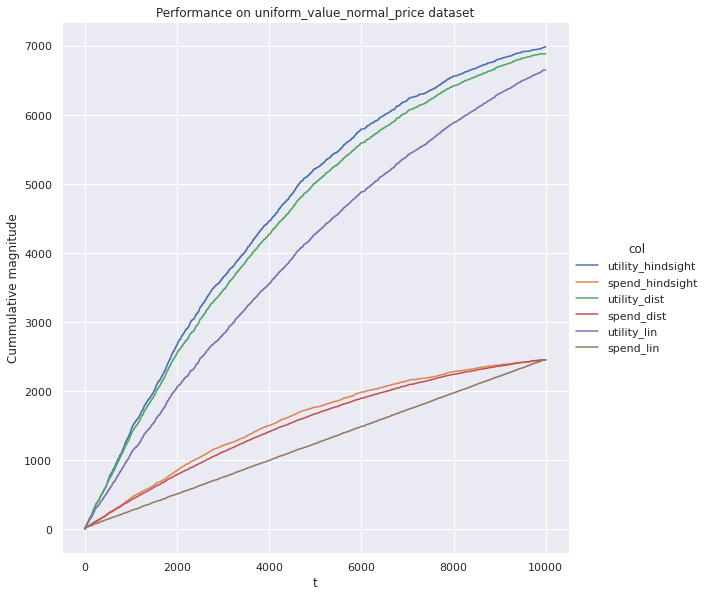

In [439]:
df_plot['col'] = df_plot[['cols', 'OC']].apply(lambda x: '_'.join(x), axis = 1)

ax = sns.relplot(
x ='index',
y ='cumm_value',
kind ='line',
hue = 'col',
height = 8,
data = df_plot
)
ax.set(xlabel='t', ylabel='Cummulative magnitude', title='Performance on uniform_value_normal_price dataset')

In [466]:
df_hindsight_cum = paced_df['hindsight'][regret_variable].cumsum()
df_regret = pd.DataFrame()
for OC in OCs:
    df_adapt_cum = paced_df[OC][regret_variable].cumsum()
    #print(df_adapt_cum)
    df_regret[OC] = df_hindsight_cum - df_adapt_cum
    df_regret[OC] =  df_regret[OC]/np.array(list(range(1, df_regret.shape[0]+1)))
    
    print("Percentage regret for %s is %f"%(OC, reg_fun(paced_df['hindsight'], paced_df[OC])  ))
    

Percentage regret for dist is 0.902489
Percentage regret for lin is 14.674182


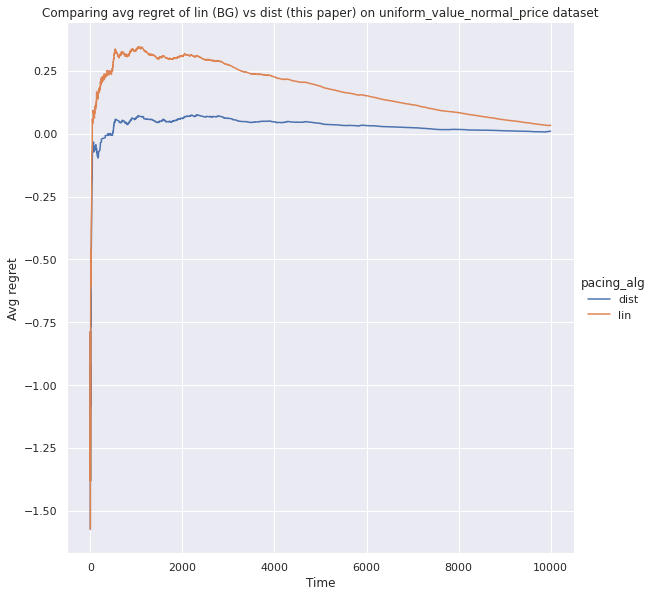

In [441]:
df_regret['index'] = df_regret.index
df_regret_tidy =  pd.melt(df_regret, id_vars=['index'], var_name='pacing_alg', value_name = 'avg_regret')

ax = sns.relplot(
kind="line",
x="index",
y="avg_regret",
hue = 'pacing_alg',
height=8,
data=df_regret_tidy
)
ax.set(xlabel='Time', ylabel='Avg regret', title='Comparing avg regret of lin (BG) vs dist (this paper) on uniform_value_normal_price dataset')

In [475]:
n = [1,10,20,50,100,200,300,1000]
#n = [10,50,500]

In [476]:
paced_df = {}
num_repeat = 5
gamma = {}
for training_samples_per_episode in n:
    gamma[training_samples_per_episode] = []
for exp_counter in range(num_repeat):
    data = uniform_val_normal_price(num_episodes, T)
    OCs =['e_hin']
    paced_df['hindsight'] = hindsight_strategy(data, budget = budget)
    for training_samples_per_episode in n:
        training_data = uniform_val_normal_price(num_episodes, training_samples_per_episode)
        target_dist_spend = estimate_spend_rate(df_samples = training_data, budget = budget, num_episodes = num_episodes, T = T)
        for OC in OCs:
            if OC == 'var':
                adaptive_pacing_df = adaptive_pacing_bg(data.copy(), target_var_spend, learning_rate)
            elif OC == 'lin':
                adaptive_pacing_df = adaptive_pacing_bg(data.copy(), target_lin_spend, learning_rate)
            elif OC == 'dist':
                adaptive_pacing_df = adaptive_pacing_bg(data.copy(), target_dist_spend, learning_rate)
            elif OC == 'e_hin':
                adaptive_pacing_df = episodic_hindsight_strategy(data.copy(), target_dist_spend, num_episodes, T)
            else:
                alpha = float(OC.split("_")[-1])
                # Mixed spend by taking convex combination
                mixed_spend = alpha * np.array(target_lin_spend) + (1-alpha)*np.array(target_var_spend)
                adaptive_pacing_df = adaptive_pacing_bg(data.copy(), mixed_spend, learning_rate)
            paced_df[OC] = adaptive_pacing_df.copy()
        reg_fun = paced_regret_u
        df_hindsight_cum = paced_df['hindsight'][regret_variable].cumsum()
        df_regret = pd.DataFrame()
        for OC in OCs:
            df_adapt_cum = paced_df[OC][regret_variable].cumsum()
            #print(df_adapt_cum)
            df_regret[OC] = df_hindsight_cum - df_adapt_cum
            df_regret[OC] =  df_regret[OC]/np.array(list(range(1, df_regret.shape[0]+1)))
            gamma[training_samples_per_episode] = gamma[training_samples_per_episode] + [reg_fun(paced_df['hindsight'], paced_df[OC])/100]

for training_samples_per_episode in n:
    gamma[training_samples_per_episode] = np.mean(gamma[training_samples_per_episode])
  

<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-9-22e0ceb6879f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

In [477]:
gamma

{1: 0.23665083362028644,
 10: 0.06987958859257566,
 20: 0.0308524441143015,
 50: 0.014419843747347432,
 100: 0.02080553760018362,
 200: 0.012149931369362422,
 300: 0.011970372959687784,
 1000: 0.011351779471486353}

Text(0.5, 1.0, 'Regret of episodic hindight on uniform_value_normal_price dataset')

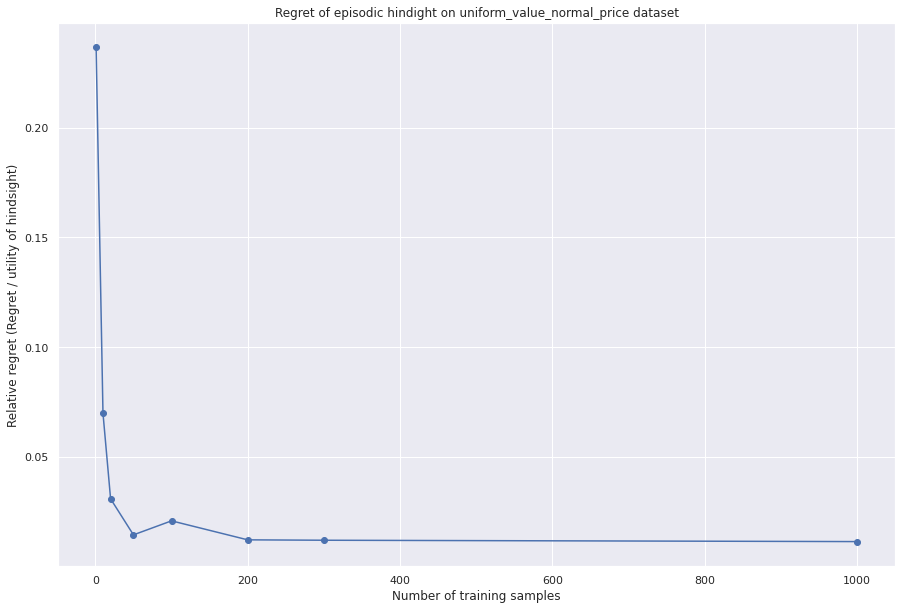

In [478]:
lists = sorted(gamma.items()) # sorted by key, return a list of tuples
x, y = zip(*lists)
plt.plot(x, y,marker="o")
plt.xlabel('Number of training samples')
plt.ylabel('Relative regret (Regret / utility of hindsight)')
plt.title('Regret of episodic hindight on uniform_value_normal_price dataset')

## Normal value, normal price

In [454]:
num_episodes = 20
T = 500
training_samples_per_episode = 1000
val_mean = uniform_samples(num_episodes, low=3, high=8)
price_mean = uniform_samples (num_episodes, low=1, high = 5)

In [456]:
data = normal_val_normal_price(num_episodes, T, val_mean, price_mean)
training_data = normal_val_normal_price(num_episodes, training_samples_per_episode, val_mean, price_mean)

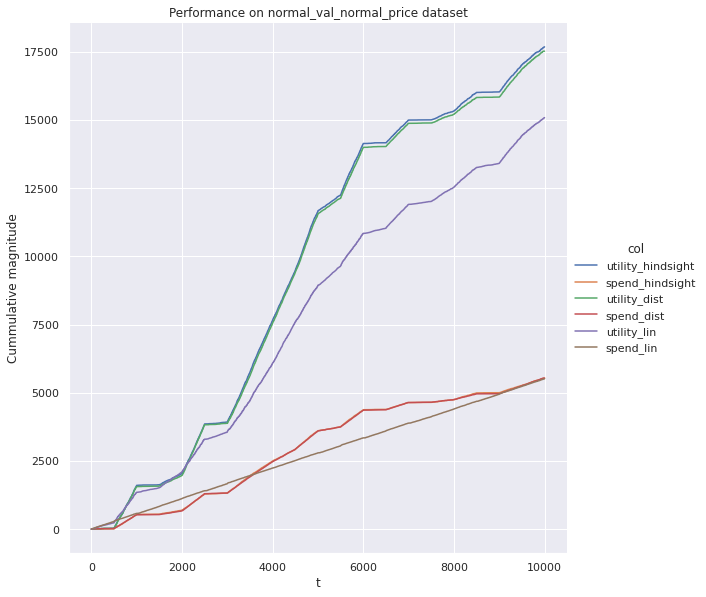

In [465]:
df_plot['col'] = df_plot[['cols', 'OC']].apply(lambda x: '_'.join(x), axis = 1)

ax = sns.relplot(
x ='index',
y ='cumm_value',
kind ='line',
hue = 'col',
height = 8,
data = df_plot
)
ax.set(xlabel='t', ylabel='Cummulative magnitude', title='Performance on normal_val_normal_price dataset')

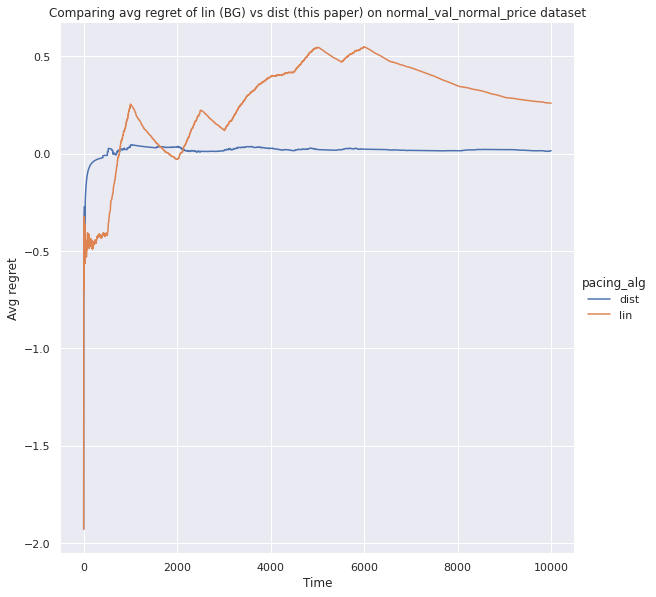

In [467]:
df_regret['index'] = df_regret.index
df_regret_tidy =  pd.melt(df_regret, id_vars=['index'], var_name='pacing_alg', value_name = 'avg_regret')

ax = sns.relplot(
kind="line",
x="index",
y="avg_regret",
hue = 'pacing_alg',
height=8,
data=df_regret_tidy
)
ax.set(xlabel='Time', ylabel='Avg regret', title='Comparing avg regret of lin (BG) vs dist (this paper) on normal_val_normal_price dataset')

In [486]:
paced_df = {}
num_repeat = 20
gamma = {}
for training_samples_per_episode in n:
    gamma[training_samples_per_episode] = []
for exp_counter in range(num_repeat):
    print (exp_counter)
    data = normal_val_normal_price(num_episodes, T, val_mean, price_mean)
    OCs =['e_hin']
    paced_df['hindsight'] = hindsight_strategy(data, budget = budget)
    for training_samples_per_episode in n:
        training_data = normal_val_normal_price(num_episodes, training_samples_per_episode, val_mean, price_mean)
        target_dist_spend = estimate_spend_rate(df_samples = training_data, budget = budget, num_episodes = num_episodes, T = T)
        for OC in OCs:
            if OC == 'var':
                adaptive_pacing_df = adaptive_pacing_bg(data.copy(), target_var_spend, learning_rate)
            elif OC == 'lin':
                adaptive_pacing_df = adaptive_pacing_bg(data.copy(), target_lin_spend, learning_rate)
            elif OC == 'dist':
                adaptive_pacing_df = adaptive_pacing_bg(data.copy(), target_dist_spend, learning_rate)
            elif OC == 'e_hin':
                adaptive_pacing_df = episodic_hindsight_strategy(data.copy(), target_dist_spend, num_episodes, T)
            else:
                alpha = float(OC.split("_")[-1])
                # Mixed spend by taking convex combination
                mixed_spend = alpha * np.array(target_lin_spend) + (1-alpha)*np.array(target_var_spend)
                adaptive_pacing_df = adaptive_pacing_bg(data.copy(), mixed_spend, learning_rate)
            paced_df[OC] = adaptive_pacing_df.copy()
        reg_fun = paced_regret_u
        df_hindsight_cum = paced_df['hindsight'][regret_variable].cumsum()
        df_regret = pd.DataFrame()
        for OC in OCs:
            df_adapt_cum = paced_df[OC][regret_variable].cumsum()
            #print(df_adapt_cum)
            df_regret[OC] = df_hindsight_cum - df_adapt_cum
            df_regret[OC] =  df_regret[OC]/np.array(list(range(1, df_regret.shape[0]+1)))
            gamma[training_samples_per_episode] = gamma[training_samples_per_episode] + [reg_fun(paced_df['hindsight'], paced_df[OC])/100]

for training_samples_per_episode in n:
    gamma[training_samples_per_episode] = np.mean(gamma[training_samples_per_episode])
  

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


Text(0.5, 1.0, 'Regret of episodic hindight on normal_val_normal_price dataset')

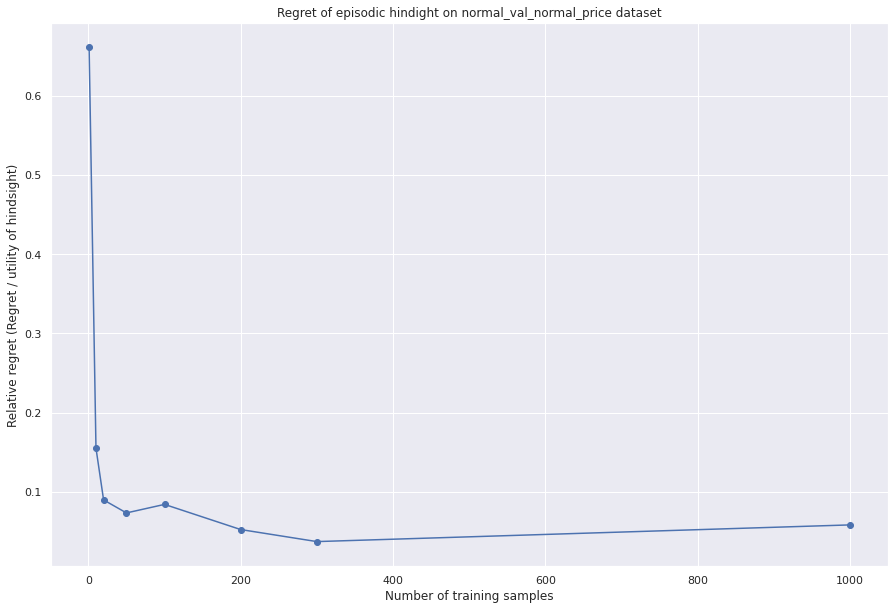

In [482]:
lists = sorted(gamma.items()) # sorted by key, return a list of tuples
x, y = zip(*lists)
plt.plot(x, y,marker="o")
plt.xlabel('Number of training samples')
plt.ylabel('Relative regret (Regret / utility of hindsight)')
plt.title('Regret of episodic hindight on normal_val_normal_price dataset')

In [483]:
gamma

{1: 0.6610376208502444,
 10: 0.15517384793636665,
 20: 0.0898061031090108,
 50: 0.07339957390121071,
 100: 0.08416589197955479,
 200: 0.05241354553381529,
 300: 0.03721756452755634,
 1000: 0.058284380759355506}

In [485]:
pd.set_option('mode.chained_assignment', None)